## **Import Dependencies**

In [ ]:
import os
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image

## **Create Custom Dataset Class**

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label


## **Paths to dataset and labels**

In [ ]:
root_dir = '/content/drive/MyDrive/DL/data/new_dataset'
csv_filename = '/content/drive/MyDrive/DL/data/dataset_labels.csv'

In [ ]:
dataset = CustomDataset(csv_file=csv_filename, root_dir=root_dir, transform=transform)
dataset

# **Split data into Train, Test, and Validation splits**

In [ ]:
train_val_split = int(len(dataset) * 0.9)
test_split = len(dataset) - train_val_split
train_val_dataset, test_dataset = random_split(dataset, [train_val_split, test_split])

In [ ]:
train_split = int(train_val_split * 0.88)
val_split = train_val_split - train_split
train_dataset, val_dataset = random_split(train_val_dataset, [train_split, val_split])

In [ ]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## **Calcualte Mean and Standard Deviation of Training Data**

In [ ]:
mean = 0.
std = 0.
total_samples = 0

In [ ]:
for inputs, _ in train_loader:
    batch_samples = inputs.size(0)
    inputs = inputs.view(batch_samples, inputs.size(1), -1)
    mean += inputs.mean(2).sum(0)
    std += inputs.std(2).sum(0)
    total_samples += batch_samples

In [ ]:
mean /= total_samples
std /= total_samples

In [ ]:
print("Mean:", mean)
print("Std:", std)


Mean: tensor([ 0.3169, -0.2145, -0.2788])
Std: tensor([1.0315, 0.8346, 0.7160])


#**Data Augmentation and Normalization**

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(112),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[ 0.3169, -0.2145, -0.2788], std=[1.0315, 0.8346, 0.7160]),
])

In [ ]:
train_dataset = CustomDataset(csv_file=csv_filename, root_dir=root_dir, transform=train_transform)

In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[ 0.3169, -0.2145, -0.2788], std=[1.0315, 0.8346, 0.7160]),
])

In [ ]:
val_dataset = CustomDataset(csv_file=csv_filename, root_dir=root_dir, transform=val_transform)
test_dataset = CustomDataset(csv_file=csv_filename, root_dir=root_dir, transform=val_transform)


# **Create a Mini ArcFace Network**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class MiniNetwork(nn.Module):
    def __init__(self, num_classes):
        super(MiniNetwork, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.zeros_(self.conv1.bias)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.zeros_(self.conv2.bias)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv3.weight, nonlinearity='relu')
        nn.init.zeros_(self.conv3.bias)

        # Layer 4 (Fully Connected)
        self.fc1 = nn.Linear(128 * 112 * 112, num_classes)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [ ]:
num_classes = 20

In [ ]:
model = MiniNetwork(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.95)

# **Training Loop**

In [ ]:
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


# **Evaluate the Model**

In [ ]:
model.eval()
total_correct = 0
total_samples = 0


In [ ]:
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples
print(f'Validation Accuracy: {accuracy * 100:.2f}%')


Validation Accuracy: 73.46%


# **Hyperparameter Tuning**

In [ ]:
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
momentums = [0.9, 0.95, 0.99]

In [ ]:
best_lr = None
best_momentum = None
best_validation_loss = float('inf')

In [ ]:
for lr in learning_rates:
    for momentum in momentums:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        num_epochs = 20
        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            model.eval()
            with torch.no_grad():
                validation_loss = 0.0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()
            if validation_loss < best_validation_loss:
                best_validation_loss = validation_loss
                best_lr = lr
                best_momentum = momentum
print(f'Best Learning Rate: {best_lr}')
print(f'Best Momentum: {best_momentum}')


Best Learning Rate: 0.001
Best Momentum: 0.99


## **Use Best parameters to train model again**

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99)

In [ ]:
num_epochs=20
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


## **Learning Rate Decay and Training and Validation Plots**

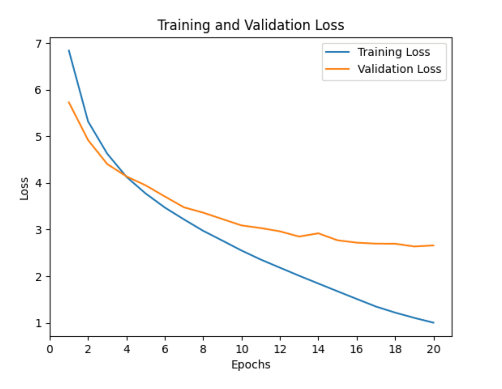

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

config = {
    'num_epochs': 20,
    'initial_lr': 0.001,
    'lr_decay_factor': 0.5,
    'lr_decay_epochs': 3,
}

initial_lr = config['initial_lr']
lr_decay_factor = config['lr_decay_factor']
lr_decay_epochs = config['lr_decay_epochs']

def adjust_learning_rate(optimizer, epoch):
    lr = initial_lr * (lr_decay_factor ** (epoch // lr_decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

train_losses = []
val_losses = []

for epoch in range(config['num_epochs']):
    model.train()
    epoch_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    epoch_val_loss /= len(val_loader)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    adjust_learning_rate(optimizer, epoch)

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## **Evaluate on test data**

In [ ]:
model.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0


In [ ]:
with torch.no_grad():
    for inputs, labels in test_loader:  # Replace val_loader with your validation or test DataLoader
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 88.79%
